In [8]:
library(MASS)
library(dplyr)
library(ggplot2)
library(mgcv)
library(e1071)
library(rpart)

Warning message:
"package 'e1071' was built under R version 3.6.3"

In [4]:
options(width=80)

In [6]:
loan3000 <- read.csv('./data/loan3000.csv')
loan_data <- read.csv('./data/loan_data.csv')
loan_data$outcome <- ordered(loan_data$outcome, levels=c('paid off', 'default'))
full_train_set <- read.csv('./data/full_train_set.csv')
full_train_set$outcome <- ordered(full_train_set$outcome, levels=c('paid off', 'default'))

In [10]:
## Naive Bayes
naive_model <- naiveBayes(outcome ~ purpose_ + home_ + emp_len_, 
                          data = na.omit(loan_data))
naive_model$table

new_loan <- loan_data[147, c('purpose_', 'home_', 'emp_len_')]
row.names(new_loan) <- NULL
new_loan

predict(naive_model, new_loan)


$purpose_
          purpose_
Y          credit_card debt_consolidation home_improvement major_purchase
  paid off  0.18759649         0.55215915       0.07150104     0.05359270
  default   0.15151515         0.57571347       0.05981209     0.03727229
          purpose_
Y             medical      other small_business
  paid off 0.01424728 0.09990737     0.02099599
  default  0.01433549 0.11561025     0.04574126

$home_
          home_
Y           MORTGAGE       OWN      RENT
  paid off 0.4894800 0.0808963 0.4296237
  default  0.4313440 0.0832782 0.4853778

$emp_len_
          emp_len_
Y            < 1 Year   > 1 Year
  paid off 0.03105289 0.96894711
  default  0.04728508 0.95271492


purpose_,home_,emp_len_
<fct>,<fct>,<fct>
small_business,MORTGAGE,> 1 Year


[1] default
Levels: paid off default

paid off,0.5347933,0.1238649
default,0.4632195,0.1233597
paid off,7.294367,4.018183
default,8.770084,4.373793


Warning message:
"Ignoring unknown parameters: arg"Warning message:
"Ignoring unknown parameters: arg"

null device 
          1

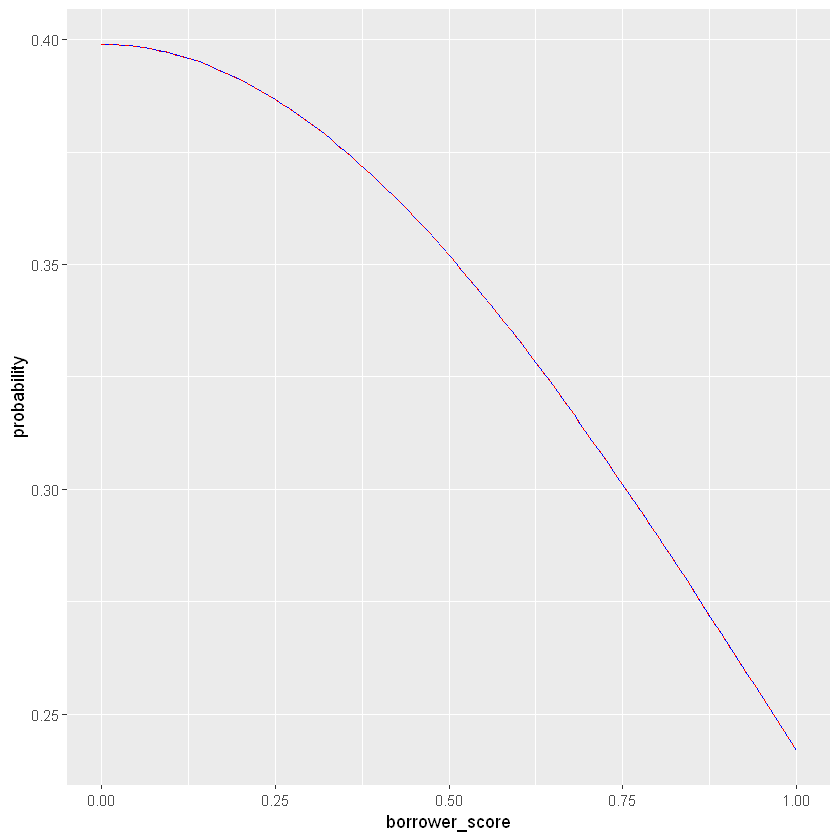

In [13]:
## example not in book
less_naive <- naiveBayes(outcome ~ borrower_score + payment_inc_ratio + 
                           purpose_ + home_ + emp_len_, data = loan_data)
less_naive$table[1:2]

stats <- less_naive$table[[1]]
ggplot(data.frame(borrower_score=c(0,1)), aes(borrower_score)) +
  stat_function(fun = dnorm, color='blue', linetype=1, 
                arg=list(mean=stats[1, 1], sd=stats[1, 2])) +
  stat_function(fun = dnorm, color='red', linetype=2, 
                arg=list(mean=stats[2, 1], sd=stats[2, 2])) +
  labs(y='probability')
dev.off()

,LD1
borrower_score,7.17583880
payment_inc_ratio,-0.09967559


,default,paid off
1,0.5535437,0.4464563
2,0.5589534,0.4410466
3,0.2726962,0.7273038
4,0.5062538,0.4937462
5,0.6099525,0.3900475
6,0.4107406,0.5892594


Warning message:
"Removed 18 rows containing missing values (geom_point)."

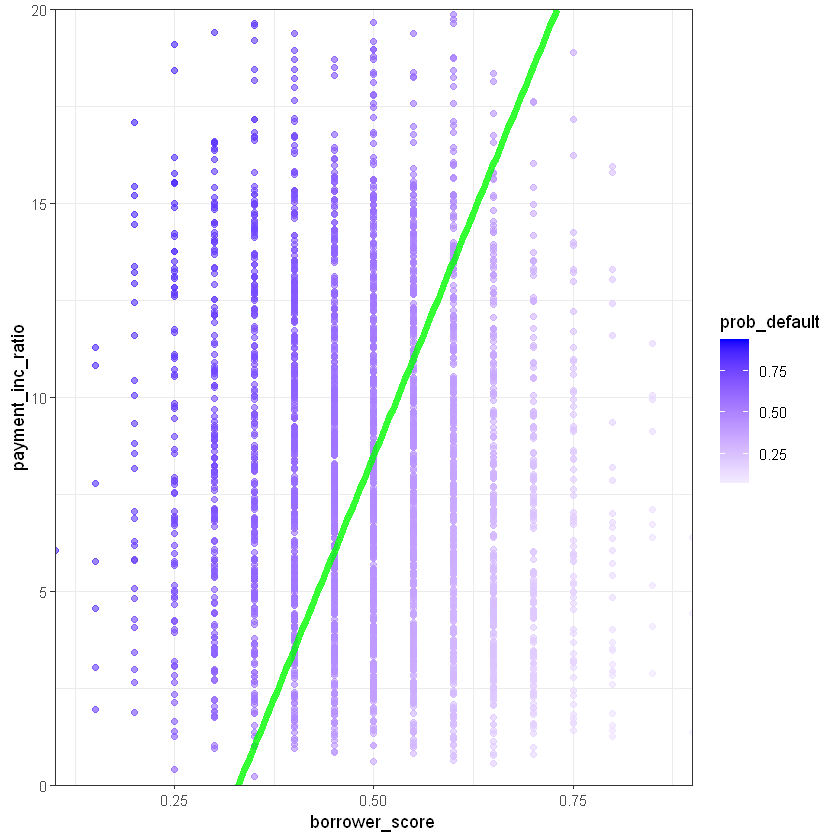

In [15]:
## Code for LDA
loan_lda <- lda(outcome ~ borrower_score + payment_inc_ratio,
                data=loan3000)
loan_lda$scaling

## Code snippet 4.2
pred <- predict(loan_lda)
head(pred$posterior)


## LDA

pred <- predict(loan_lda)
lda_df <- cbind(loan3000, prob_default=pred$posterior[,'default'])

x <- seq(from=.33, to=.73, length=100)
y <- seq(from=0, to=20, length=100)
newdata <- data.frame(borrower_score=x, payment_inc_ratio=y)
pred <- predict(loan_lda, newdata=newdata)
lda_df0 <- cbind(newdata, outcome=pred$class)

ggplot(data=lda_df, aes(x=borrower_score, y=payment_inc_ratio, color=prob_default)) +
  geom_point(alpha=.6) +
  scale_color_gradient2(low='white', high='blue') +
  scale_x_continuous(expand=c(0,0)) + 
  scale_y_continuous(expand=c(0,0), lim=c(0, 20)) + 
  geom_line(data=lda_df0, col='green', size=2, alpha=.8) +
  theme_bw()

In [16]:
logistic_model <- glm(outcome ~ payment_inc_ratio + purpose_ + 
                        home_ + emp_len_ + borrower_score,
                      data=loan_data, family='binomial')
logistic_model
summary(logistic_model)

p <- seq(from=0.01, to=.99, by=.01)
df <- data.frame(p = p ,
                 logit = log(p/(1-p)),
                 odds = p/(1-p))


Call:  glm(formula = outcome ~ payment_inc_ratio + purpose_ + home_ + 
    emp_len_ + borrower_score, family = "binomial", data = loan_data)

Coefficients:
               (Intercept)           payment_inc_ratio  
                   1.63809                     0.07974  
purpose_debt_consolidation    purpose_home_improvement  
                   0.24937                     0.40774  
    purpose_major_purchase             purpose_medical  
                   0.22963                     0.51048  
             purpose_other      purpose_small_business  
                   0.62066                     1.21526  
                  home_OWN                   home_RENT  
                   0.04833                     0.15732  
         emp_len_ > 1 Year              borrower_score  
                  -0.35673                    -4.61264  

Degrees of Freedom: 45341 Total (i.e. Null);  45330 Residual
Null Deviance:	    62860 
Residual Deviance: 57510 	AIC: 57540


Call:
glm(formula = outcome ~ payment_inc_ratio + purpose_ + home_ + 
    emp_len_ + borrower_score, family = "binomial", data = loan_data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.51951  -1.06908  -0.05853   1.07421   2.15528  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 1.638092   0.073708  22.224  < 2e-16 ***
payment_inc_ratio           0.079737   0.002487  32.058  < 2e-16 ***
purpose_debt_consolidation  0.249373   0.027615   9.030  < 2e-16 ***
purpose_home_improvement    0.407743   0.046615   8.747  < 2e-16 ***
purpose_major_purchase      0.229628   0.053683   4.277 1.89e-05 ***
purpose_medical             0.510479   0.086780   5.882 4.04e-09 ***
purpose_other               0.620663   0.039436  15.738  < 2e-16 ***
purpose_small_business      1.215261   0.063320  19.192  < 2e-16 ***
home_OWN                    0.048330   0.038036   1.271    0.204    
home_RENT                   0.

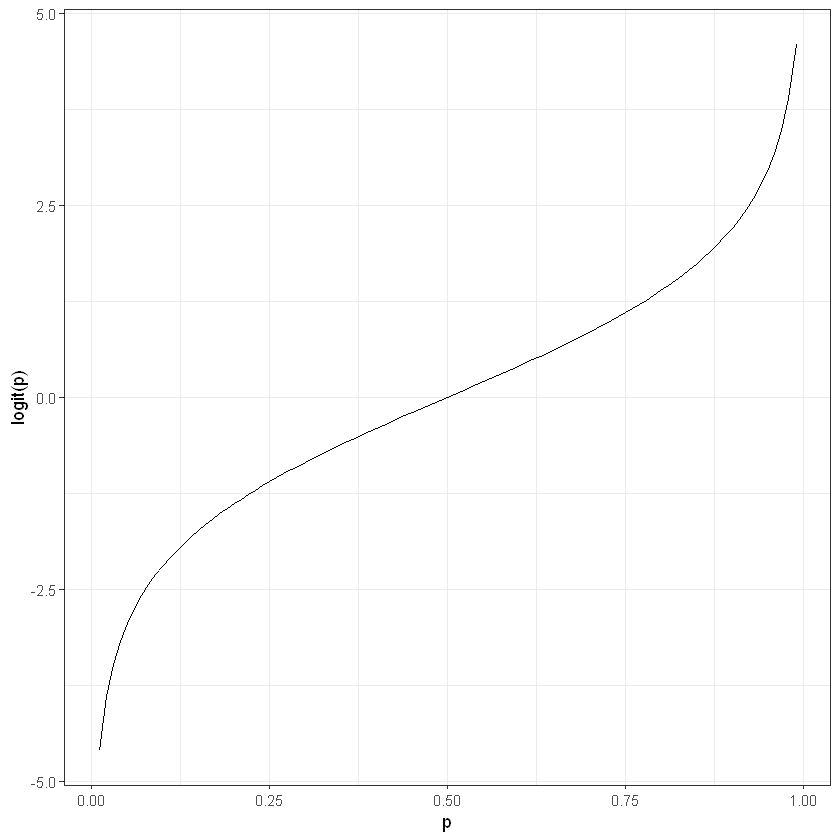

In [17]:
ggplot(data=df, aes(x=p, y=logit)) +
  geom_line() +
  labs(x = 'p', y='logit(p)') +
  theme_bw()

Warning message:
"Removed 49 row(s) containing missing values (geom_path)."

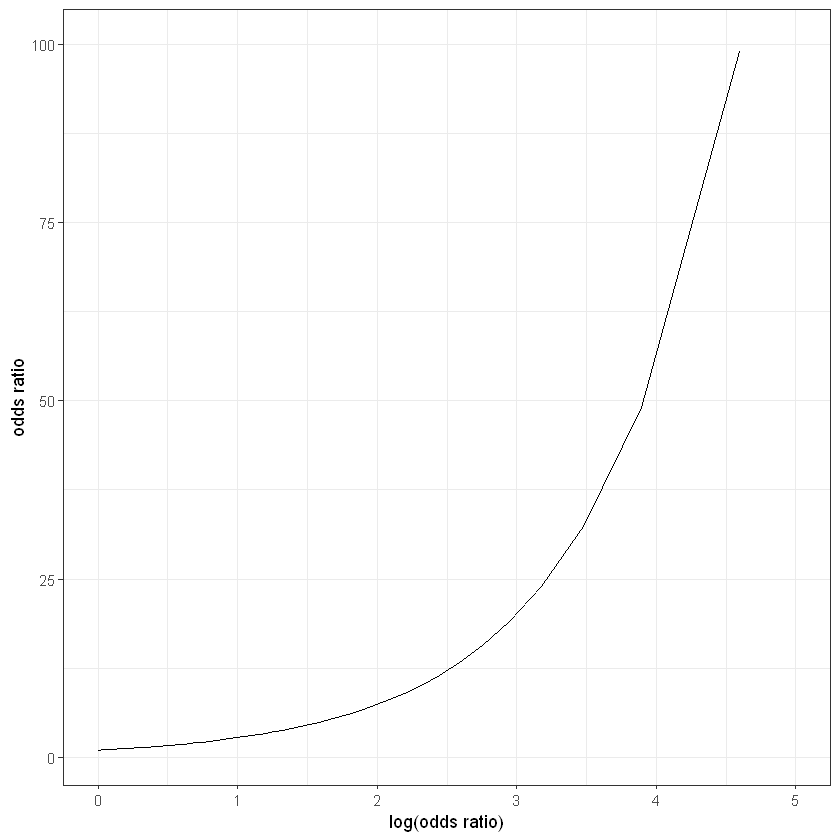

In [18]:
ggplot(data=df, aes(x=logit, y=odds)) +
  geom_line() +
  labs(x = 'log(odds ratio)', y='odds ratio') +
  ylim(1, 100) +
  xlim(0, 5) +
  theme_bw()


In [19]:

pred <- predict(logistic_model)
summary(pred)

prob <- 1/(1 + exp(-pred))
summary(prob)


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-2.704774 -0.518825 -0.008539  0.002564  0.505061  3.509606 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.06269 0.37313 0.49787 0.50000 0.62365 0.97096 


Family: binomial 
Link function: logit 

Formula:
outcome ~ s(payment_inc_ratio) + purpose_ + home_ + emp_len_ + 
    s(borrower_score)

Estimated degrees of freedom:
7.66 4.17  total = 21.83 

UBRE score: 0.2681506     

Warning message:
"Removed 9 rows containing missing values (geom_point)."Warning message:
"Removed 9 row(s) containing missing values (geom_path)."

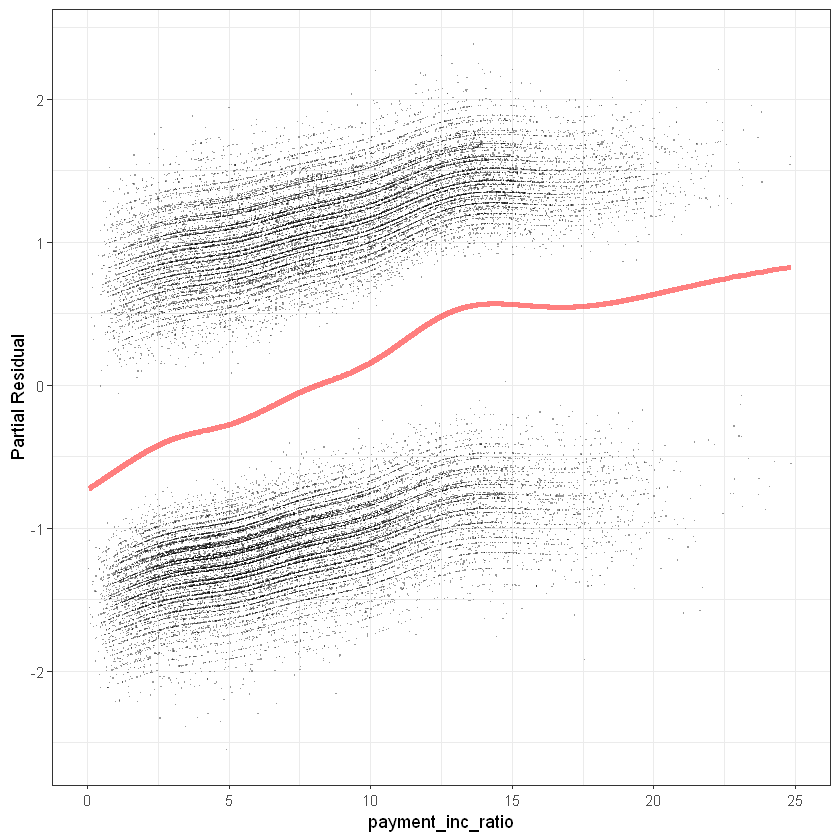

In [20]:
logistic_gam <- gam(outcome ~ s(payment_inc_ratio) + purpose_ + 
                      home_ + emp_len_ + s(borrower_score),
                    data=loan_data, family='binomial')
logistic_gam

terms <- predict(logistic_gam, type='terms')
partial_resid <- resid(logistic_gam) + terms
df <- data.frame(payment_inc_ratio = loan_data[, 'payment_inc_ratio'],
                 terms = terms[, 's(payment_inc_ratio)'],
                 partial_resid = partial_resid[, 's(payment_inc_ratio)'])
  

ggplot(df, aes(x=payment_inc_ratio, y=partial_resid, solid = FALSE)) +
  geom_point(shape=46, alpha=.4) +
  geom_line(aes(x=payment_inc_ratio, y=terms), 
            color='red', alpha=.5, size=1.5) +
  labs(y='Partial Residual') +
  xlim(0, 25) +
  theme_bw()


,Yhat = 1,Yhat = 0
Y = 1,14293,8378
Y = 0,8051,14620


[1] 0.6396796

[1] 0.630453

[1] 0.6448767

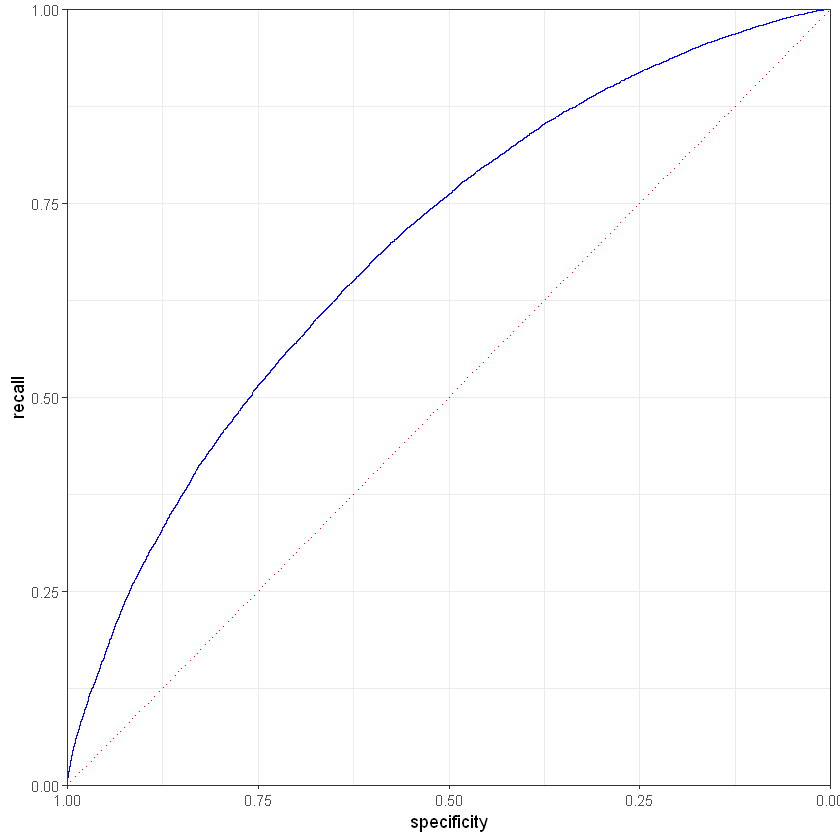

In [22]:
# Confusion matrix
pred <- predict(logistic_gam, newdata=loan_data)
pred_y <- as.numeric(pred > 0)
true_y <- as.numeric(loan_data$outcome=='default')
true_pos <- (true_y==1) & (pred_y==1)
true_neg <- (true_y==0) & (pred_y==0)
false_pos <- (true_y==0) & (pred_y==1)
false_neg <- (true_y==1) & (pred_y==0)
conf_mat <- matrix(c(sum(true_pos), sum(false_pos),
                     sum(false_neg), sum(true_neg)), 2, 2)
colnames(conf_mat) <- c('Yhat = 1', 'Yhat = 0')
rownames(conf_mat) <- c('Y = 1', 'Y = 0')
conf_mat

# precision
conf_mat[1,1]/sum(conf_mat[,1])
# recall
conf_mat[1,1]/sum(conf_mat[1,])
# specificity
conf_mat[2,2]/sum(conf_mat[2,])

## Code for Figure 5-6
idx <- order(-pred)
recall <- cumsum(true_y[idx]==1)/sum(true_y==1)
specificity <- (sum(true_y==0) - cumsum(true_y[idx]==0))/sum(true_y==0)
roc_df <- data.frame(recall = recall, specificity = specificity)
ggplot(roc_df, aes(x=specificity, y=recall)) +
  geom_line(color='blue') + 
  scale_x_reverse(expand=c(0, 0)) +
  scale_y_continuous(expand=c(0, 0)) + 
  geom_line(data=data.frame(x=(0:100)/100), aes(x=x, y=1-x),
            linetype='dotted', color='red') +
  theme_bw()

[1] 0.6926232

,recall,specificity
,<dbl>,<dbl>
1,4.410921e-05,1.0000000
2,8.821843e-05,1.0000000
3,8.821843e-05,0.9999559
4,1.323276e-04,0.9999559
5,1.764369e-04,0.9999559
6,2.205461e-04,0.9999559


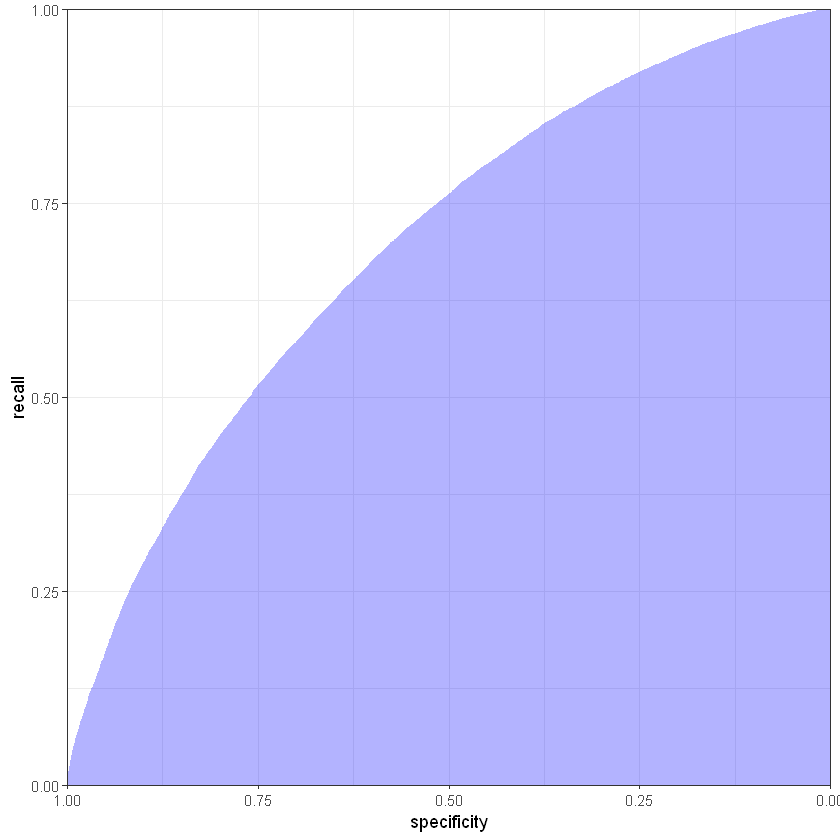

In [23]:
ggplot(roc_df, aes(specificity)) +
  geom_ribbon(aes(ymin=0, ymax=recall), fill='blue', alpha=.3) +
  scale_x_reverse(expand=c(0, 0)) +
  scale_y_continuous(expand=c(0, 0)) +
  labs(y='recall') +
  theme_bw()

## AUC calculation
sum(roc_df$recall[-1] * diff(1-roc_df$specificity))
head(roc_df)

In [24]:
## Code for Undersampling
mean(full_train_set$outcome=='default')

full_model <- glm(outcome ~ payment_inc_ratio + purpose_ + 
                    home_ + emp_len_+ dti + revol_bal + revol_util,
                  data=full_train_set, family='binomial')
pred <- predict(full_model)
mean(pred > 0)

## Code for oversampling/up weighting
wt <- ifelse(full_train_set$outcome=='default', 1/mean(full_train_set$outcome == 'default'), 1)
full_model <- glm(outcome ~ payment_inc_ratio + purpose_ + 
                    home_ + emp_len_+ dti + revol_bal + revol_util,
                  data=full_train_set, weight=wt, family='quasibinomial')
pred <- predict(full_model)
mean(pred > 0)

[1] 0.1889455

[1] 0.003942094

[1] 0.5767208